# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

- Load the twitter sentiment dataset, set the index, calculate the engagement ratio and filter out the stocks with no significant twitter activity.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

sentiment_df = pd.read_csv('sentiment_data.csv')

In [82]:
sentiment_df = sentiment_df.drop(sentiment_df[sentiment_df['symbol'] == 'ATVI'].index)
sentiment_df.columns

Index(['date', 'symbol', 'twitterPosts', 'twitterComments', 'twitterLikes',
       'twitterImpressions', 'twitterSentiment'],
      dtype='object')

In [83]:
sentiment_df
# Change date and time to integer values so that the algorithm can parse the values

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [84]:
# Switches the date and symbol to act as the indexes for our sentiments
sentiment_df = sentiment_df.set_index(['date', 'symbol'])

In [85]:
## Calculate the engagement ratio using the comments and likes so that
## you can avoid stocks that are botted 

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

In [86]:
sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] >20)&(sentiment_df['twitterComments'] >10)]

In [87]:
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           BA              61.0             55.0         342.0   
           CRM             25.0           7183.0       29832.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           BA                425847.0               NaN          0.160819  
           CRM               142826.0               NaN          0.240782  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[24994 rows x 6 columns]

## 2. Aggregate Monthly and calculate average sentiment for the month
- Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [88]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='ME'), 'symbol'])
[['engagement_ratio']].mean())



In [89]:
# Rank the stocks based on the engagement ratio that we calculated above

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                        .transform(lambda x: x.rank(ascending=False)))

## Select the Top 5 Stocks based on their cross-sectional rankting for each month
- Select the stocks by ranks for each month, and fix the date to start at the beginning of the next month

In [90]:
## Create a filtered data frame that captures the top 5 ranked stocks

filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

In [91]:
## Resetting the dates

filtered_df = filtered_df.reset_index(level=1)
filtered_df

,symbol,engagement_ratio,rank
date,,,
2021-11-30,AES,0.864613,2.0
2021-11-30,FCX,0.626323,5.0
2021-11-30,MNST,0.699721,3.0
2021-11-30,OXY,2.147741,1.0
2021-11-30,SLB,0.647374,4.0
...,...,...,...
2023-01-31,A,0.471572,5.0
2023-01-31,AES,0.533809,4.0
2023-01-31,BIIB,0.839303,1.0


In [92]:
## Offsets the date by adding an extra day

filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df

,symbol,engagement_ratio,rank
date,,,
2021-12-01,AES,0.864613,2.0
2021-12-01,FCX,0.626323,5.0
2021-12-01,MNST,0.699721,3.0
2021-12-01,OXY,2.147741,1.0
2021-12-01,SLB,0.647374,4.0
...,...,...,...
2023-02-01,A,0.471572,5.0
2023-02-01,AES,0.533809,4.0
2023-02-01,BIIB,0.839303,1.0


In [93]:
## Reset the multi index to get all the top 5 for each month within the same index

filtered_df = filtered_df.reset_index().set_index(['date','symbol'])

In [94]:
filtered_df.head(5)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0

## 4. Extract the stocks to form portfolios with at the start of each new month
- Create a dictionary containing start of the month and corresponding stocks

In [95]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

In [96]:
fixed_dates = {}

In [97]:
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

## 5. Download fresh stock prices for only the selected stocks

In [98]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers = stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

[*********************100%%**********************]  84 of 84 completed


## 6. Calculate Portfolio Returns with monthly rebalancing

In [112]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    print(start_date)
    cols = fixed_dates[start_date]
    print(cols)

    ## Calculate equally weighted daily returns
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)


2021-12-01
['AES', 'FCX', 'MNST', 'OXY', 'SLB']
2022-01-01
['D', 'FCX', 'L', 'LUV', 'MA']
2022-02-01
['AMD', 'D', 'FCX', 'LUV', 'MA']
2022-03-01
['FCX', 'GILD', 'LUV', 'MRO', 'OXY']
2022-04-01
['A', 'CRM', 'PFE', 'PM', 'STZ']
2022-05-01
['AMD', 'CRM', 'CVX', 'J', 'KEY']
2022-06-01
['AMD', 'DD', 'FCX', 'KEY', 'LMT']
2022-07-01
['CB', 'CRM', 'DD', 'FCX', 'STZ']
2022-08-01
['A', 'DD', 'JPM', 'REGN', 'STZ']
2022-09-01
['ABT', 'DIS', 'L', 'META', 'MRNA']
2022-10-01
['J', 'KEY', 'L', 'META', 'MU']
2022-11-01
['A', 'DD', 'FCX', 'J', 'META']
2022-12-01
['AEP', 'AES', 'DD', 'J', 'STZ']
2023-01-01
['A', 'AES', 'DAL', 'J', 'KEY']
2023-02-01
['A', 'AES', 'BIIB', 'FCX', 'MDT']


In [114]:

portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


## 7. Download NASDAQ/QQQ prices and calculate returns to compare our strategy

In [115]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


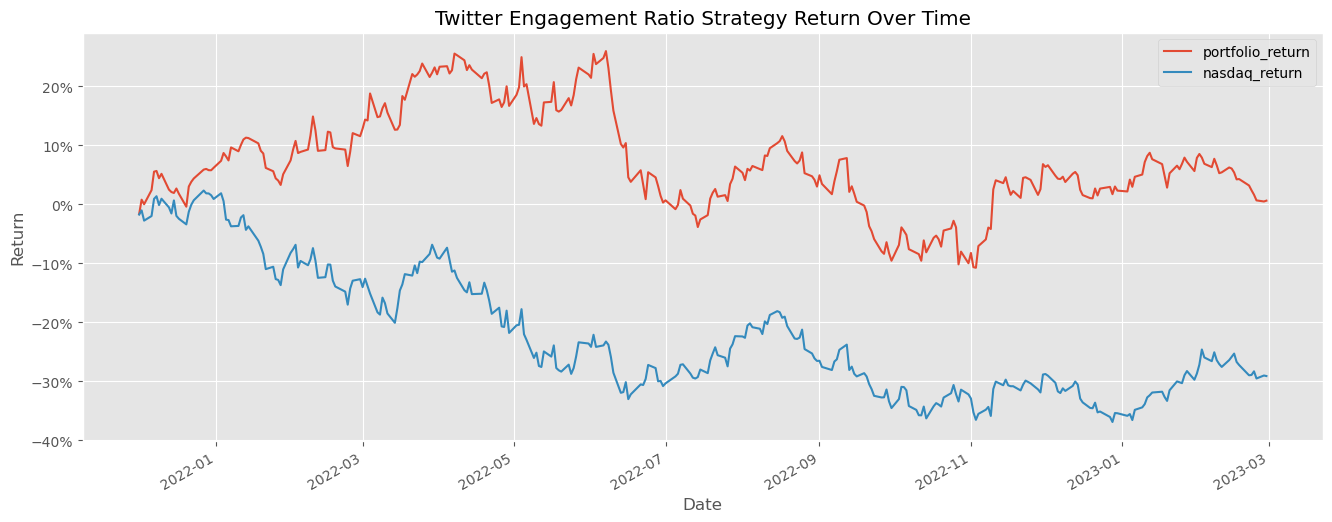

In [116]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()